In [1]:
%pylab inline
from sys import platform
from tqdm import trange
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'
    
%run TermSelection.ipynb

Populating the interactive namespace from numpy and matplotlib


In [2]:
### LOADS PROCESSED DATA

c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

In [ ]:
### PRINTS COMMNET COUNT PER DAY OVER TIME
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(comments)

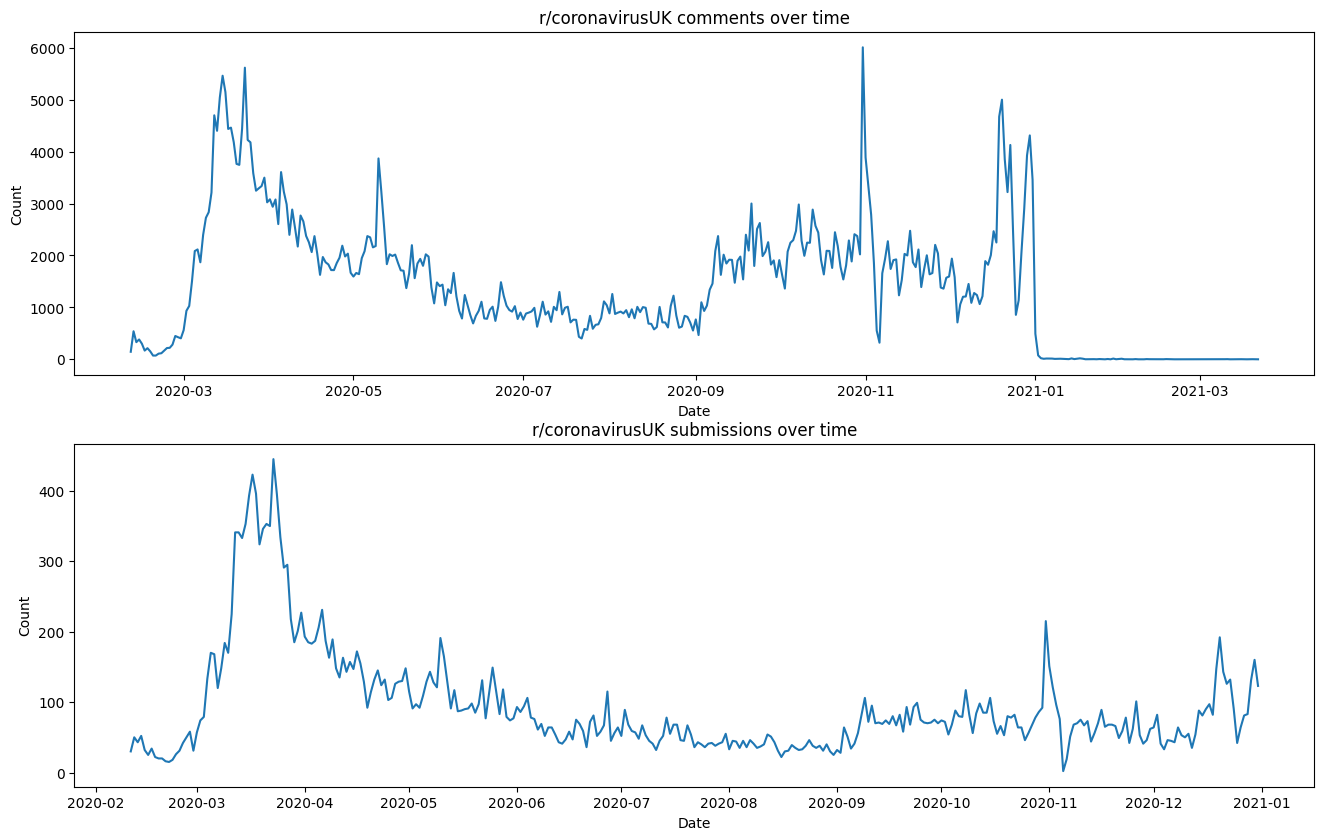

In [3]:
### PLOTTING COMMENTS AND SUBMISSIONS ON r/coronavirusUK OVER TIME

comments = c_df['datetime'].dt.date.value_counts()
submissions = s_df['datetime'].dt.date.value_counts()

submissions = submissions.sort_index(ascending=True)
comments = comments.sort_index(ascending=True)

fig, (ax1, ax2) = plt.subplots(2, dpi=100)
fig.set_size_inches(16, 10)

ax1.set_title('r/coronavirusUK comments over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.plot(comments.index, comments.values)

ax2.set_title('r/coronavirusUK submissions over time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.plot(submissions.index, submissions.values)

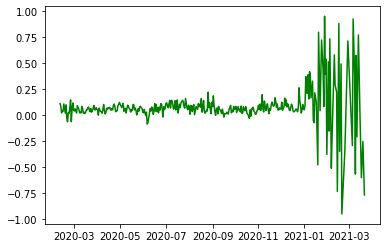

In [55]:
### PLOTTING MEAN SENTIMENT OF ALL COMMENTS PER DAY OVER TIME

non_neutral_comments = c_df.query(
    'sentiment != "neutral"'
).groupby(
    c_df['datetime'].dt.date
).agg(
    {
        'compound_score': mean
    }
)

plt.plot(non_neutral_comments, 'g')

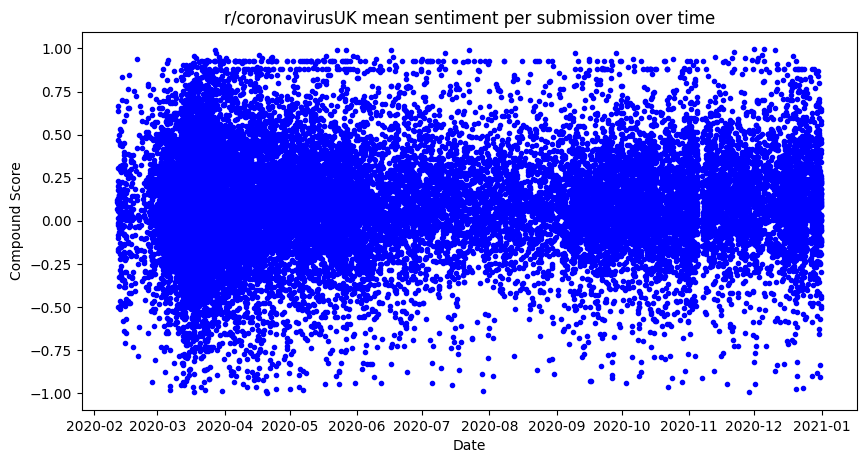

In [5]:
### PLOTTING NON-NEUTRAL COMMENTS BY SUBMISSION ON r/coronavirusUK OVER TIME')

### SUBMISSION COMPOUND SCORE CALCULATED BY MEAN OF COMMENTS FROM EACH SUBMISSION
agg_sub_compound_score = c_df.query(
    'sentiment != "neutral"'
).groupby(
    c_df['submission_id']
).agg(
    {
        'compound_score': mean
    }
)

### MERGES SUB DATAFRAME WITH MEAN COMPOUND SCORE FOR ALL COMMENTS OF EACH SUBMISSION
sub_comments = pd.merge(s_df, agg_sub_compound_score, left_index=True, right_index=True)

fig, ax1 = plt.subplots(1, dpi=100)
fig.set_size_inches(10, 5)

ax1.set_title('r/coronavirusUK mean sentiment per submission over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Compound Score')
ax1.plot(sub_comments['datetime'], sub_comments['compound_score'], 'b.')

In [6]:
### TRANSFORMS COMMENT DATAFRAME INTO DICTIONARY TO BE VECTORIZED

df_to_dict = c_df.copy().query('sentiment != "neutral"').reset_index()
df_to_dict['target'] = df_to_dict.apply(lambda x: get_target(x['sentiment']), axis=1)
df_to_dict = df_to_dict.drop(columns=['datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'])
df_dict = {'body': list(df_to_dict['body']), 'target': list(df_to_dict['target'])}

In [19]:
x

range(0, 25)

<BarContainer object of 25 artists>

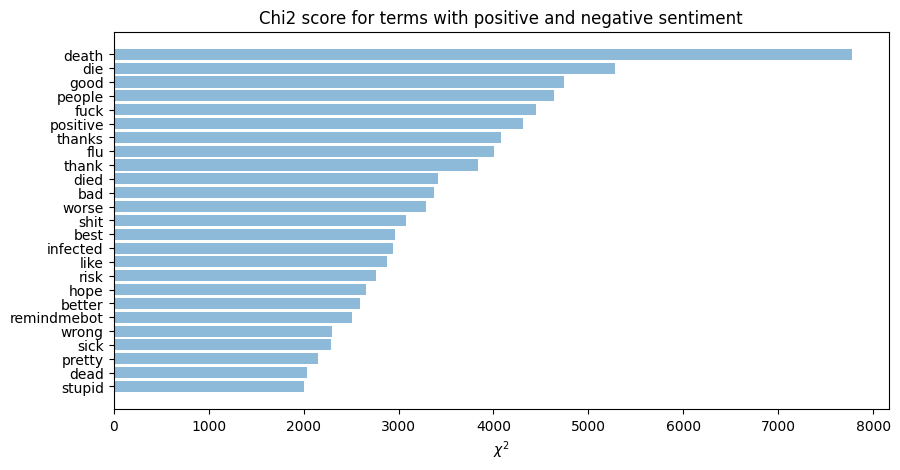

In [52]:
### RETURNS THE TOP N TERMS
topchi2 = document_vectorizer(df_dict, 25)

x = range(len(topchi2[1]))
labels = topchi2[0]

fig, ax1 = plt.subplots(1, dpi=100)
fig.set_size_inches(10, 5)

ax1.set_title('Chi2 score for terms with positive and negative sentiment')
ax1.set_xlabel('$\chi^2$')
ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.barh(x, topchi2[1], align='center', alpha=0.5)

In [ ]:
### LATENT DIRICHLET ALLOCATION (LDA)

import re


# Remove punctuation



In [56]:
c_df.sample(10)

,datetime,body,sentiment,compound_score,submission_id,parent_id
id,,,,,,
fxawpb8,2020-07-08 12:26:30,Free biscuits for everybody named Keith!,positive,0.5562,hnf7b4,t3_hnf7b4
gbmkav0,2020-11-08 16:59:19,He only has to extend self-isolation if he sti...,negative,-0.1280,jq2hq1,t1_gbm21ln
gd9n4xj,2020-11-22 22:09:23,"If the first vaccine did do 90% of the work, a...",positive,0.3964,jz2zqk,t1_gd9jlwr
g9mswvq,2020-10-22 10:59:14,[deleted],neutral,0.0000,jfwmqo,t3_jfwmqo
gaoeh6a,2020-10-31 06:16:10,Ealing has 220/100k for the highest London bor...,neutral,0.0000,jl6h0x,t1_ganlzvh
fm60zdy,2020-04-02 00:33:37,Why?,neutral,0.0000,ft54af,t1_fm51hd2
g23i5lt,2020-08-19 14:02:37,They aren't. Mate of mine arrived in the UK fr...,neutral,0.0000,iar4is,t3_iar4is
g2wjykr,2020-08-26 13:34:54,"Ok, so I live in a bubble because I don’t live...",negative,-0.3612,if1y2c,t1_g2vckoz
g83gjti,2020-10-08 11:24:00,Good on you. I finished in April and told anyo...,negative,-0.7019,j79nhy,t1_g83ef9w


In [ ]:
s_df.sample(5)